In [1]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

### Preprocessing the data:

In [2]:
np.random.seed(42)

#Importing the dataset
dataset = pd.read_csv('train.csv')

#Shuffling the dataset
dataset = dataset.sample(frac=1, random_state=42)

#Making sure the dataset is balanced
train_data = pd.DataFrame()
test_data = pd.DataFrame()
for label in range (10):
    train_label_data = dataset[dataset['label']==label].head(500)
    test_label_data = dataset[dataset['label']==label].iloc[500:600,:]
    train_data = pd.concat([train_data, train_label_data])
    test_data = pd.concat([test_data, test_label_data])

#One hot encoding the labels
def one_hot_encoding(df, column_name):
    one_hot_labels = pd.get_dummies(df[column_name])
    dff = pd.concat([df,one_hot_labels], axis=1)
    dff.drop(column_name, axis = 1, inplace = True) 
    return dff

train_data = one_hot_encoding(train_data, 'label')
test_data = one_hot_encoding(test_data, 'label')

In [3]:
train_data.reset_index(drop=True, inplace=True)

In [4]:
#From dataframes to numpy arrays
X_train = train_data.iloc[:, 0:784].values
X_test = test_data.iloc[:, 0:784].values
y_train = train_data.iloc[:, 784:794].values
y_test = test_data.iloc[:, 784:794].values

In [5]:
#Reshaping the data
X_train_r = np.zeros((X_train.shape[0], 1, 28, 28), dtype=np.float64)
X_test_r = np.zeros((X_test.shape[0], 1, 28, 28), dtype=np.float64)

for im in range(X_train_r.shape[0]):
    X = X_train[im,:]
    X = np.ravel(X)
    X = X.reshape((1, 28, 28))
    X_train_r[im,0,:,:] = X
X_train = X_train_r
for im in range (X_test_r.shape[0]):
    X = X_test[im,:]
    X = np.ravel(X)
    X = X.reshape((1, 28, 28))
    X_test_r[im,0,:,:] = X
X_test = X_test_r

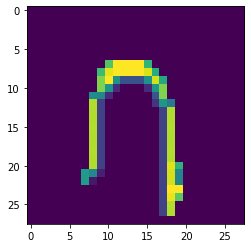

In [6]:
%matplotlib inline
plt.imshow(X_train[800][0], interpolation='nearest')
plt.show()

### Convolution and generating the Feature Map:

#### The filters

In [7]:
conv0 = np.random.randn(2,1,5,5)
conv1 = conv0 * np.sqrt(1. / 5)
conv1.shape[3]

5

#### Generating the feature map

In [8]:
#The stride is 1
def conv_layers(data, filters):
    fearture_map_dim = len(X_train[0][0])-len(conv1[0][0])+1
    feature_map = np.zeros((X_train.shape[0], conv1.shape[0], fearture_map_dim, fearture_map_dim))
    for i in range (X_train.shape[0]):
        image = X_train[i][0]
        for j in range (conv1.shape[0]):
            filt = conv1[j][0]
            for d1 in range(fearture_map_dim):
                s1 = d1
                e1 = s1 + conv1.shape[3]
                for d2 in range(fearture_map_dim):
                    s2 = d2
                    e2 = s2 + conv1.shape[3]
                    im_section = image[s1:e1, s2:e2]
                    feature_section = np.dot(im_section, filt)
                    feature = np.sum(feature_section)
                    feature_map[i][j][d1][d2] = feature
    return feature_map

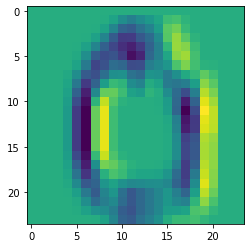

In [9]:
feature_map = conv_layers(X_train, conv1)
plt.imshow(feature_map[0][0], interpolation='nearest')
plt.show()

In [48]:
feature_map.shape[2]

24

### Useful functions:

#### ReLu

In [10]:
def ReLu(x):
    return (x>0)*x

#### MaxPool

In [78]:
def MaxPool(feature_map, stride=2):
    filter_dim = 2
    output_dim = int((feature_map.shape[2]-filter_dim)/stride)+1
    pooled_list = []
    pooled_rows = np.empty(shape=[filter_dim, output_dim])
    pooled_features = np.zeros((feature_map.shape[0], feature_map.shape[1], output_dim, output_dim))
    
    for i in range(feature_map.shape[0]):
        for j in range(feature_map.shape[1]):
            image = feature_map[i][j]
            for d1 in range (0, feature_map.shape[2], stride):
                start1 = d1 #if d1 ==0 else d1*2)
                end1 = d1 + filter_dim
                if end1<=feature_map.shape[2]:
                    image_rectangle =image[start1:end1, :]
                    for d2 in range (0, feature_map.shape[2], stride):
                        start2 = d2 #if d2 ==0 else d1*2)
                        end2 = d2 + filter_dim
                        if end2<=feature_map.shape[2]:
                            image_section = image_rectangle[:,start2:end2]
                            pooled_section = np.amax(image_section)
                            pooled_list.append(pooled_section)      
                    if (pooled_list != []):
                        pooled_row = np.array(pooled_list)
                        pooled_row = np.reshape(pooled_row, (1, output_dim))
                        pooled_rows = np.concatenate((pooled_rows, pooled_row), axis = 0)
                        pooled_list.clear()
            pooled_features[i][j] = pooled_rows[1:13,:]
    return pooled_features

In [79]:
pooled_features1 = MaxPool(feature_map)

In [80]:
pooled_features1.shape

(5000, 2, 12, 12)

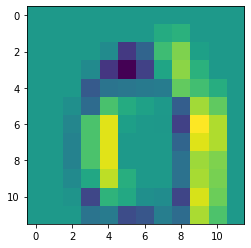

In [81]:
plt.imshow(pooled_features1[0][0], interpolation='nearest')
plt.show()

#### Softmax:

In [ ]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), dim=1, keepdims = True)

### Initialising the network:

In [ ]:
input_dim = feature_map.shape[1]
hidden_dim1 = 256
hidden_dim2 = 256
output_dim = 10
lambda_reg = 0.01

In [ ]:
def network_innit(input_dim, hidden_dim1, hidden_dim2, output_dim):
    model_dict = {}
    W1 = np.random.randn((input_dim, hidden_dim1))
    W2 = np.random.randn((hidden_dim1, hidden_dim2))
    W3 = np.random.randn((hidden_dim2, output_dim))
    b1 = np.zeros((1, hidden_dim1))
    b2 = np.zeros((1, hidden_dim2))
    b3 = np.zeros((1, output_dim))
    model_dict['W1'] = W1
    model_dict['W2'] = W2
    model_dict['W3'] = W3
    model_dict['b1'] = b1
    model_dict['b2'] = b2
    model_dict['b3'] = b3
    return model_dict

### Forward Propagation:

In [ ]:
model_dict = network_innit(input_dim, hidden_dim1, hidden_dim2, output_dim)
def get_param (model_dict):
    W1 = model_dict['W1']
    W2 = model_dict['W2']
    W3 = model_dict['W3']
    b1 = model_dict['b1']
    b2 = model_dict['b2']
    b3 = model_dict['b3']
    
    return W1, W2, W3, b1, b2, b3

In [ ]:
def forward(input_data, model_dict, filters):
    W1, W2, W3, b1, b2, b3 = get_param(model_dict)
    feature_map = conv_layers(input_data, filters)
    activated_fm = ReLu(feature_map)
    pooled_features = MaxPool(activated_fm)
    X = pooled_features.reshape(pooled_features.shape[0], -1)
    z1 = X.dot(W1) + b1
    a1 = Relu(z1)
    z2 = a1.dot(W2) + b2
    a2 = Relu(z2)
    z3 = a2.dot(W3) + b3
    peridct = softmax(z3)
    return peridict

In [ ]:
def get_predictions(predict):
    return np.argmax(predict, axis=1)

### Loss:

In [ ]:
def cross_entropy (predictions, labels):
    W1, W2, W3, b1, b2, b3 = get_param(model_dict)
    m = np.zeros(predictions.shape[0])
    for i, correct_predict in enumerate(labels):
        m[i] = predictions[i][correct_predict]
    log_prob = - np.log(m)
    loss = np.sum(log_prob)
    reg_loss = (lambda_reg / 2)*(np.sum(np.sum(W1)+np.sum(W2)))
    loss += reg_loss
    return float(loss/labels.shape[0])

### Back Propagation:

In [ ]:
def backprog(model_dict, )